In [1]:
import opera_utils
import pandas as pd
import geopandas as gpd
import asf_search as asf
from datetime import datetime
from shapely import Polygon
import warnings
warnings.filterwarnings("ignore")

### Read in the data and add needed columns

In [2]:
df_burst_geoms = opera_utils.get_burst_id_geojson(True).drop_duplicates(subset='burst_id_jpl', keep='first')
df_burst_geoms['pathNumber'] = df_burst_geoms['burst_id_jpl'].str.extract(r't(\d+)_').astype(int)
df_burst_geoms['flightDirection'] = df_burst_geoms['orbit_pass']
df_burst_geoms = df_burst_geoms.drop(columns=['orbit_pass'])
df_burst_geoms = df_burst_geoms.reset_index(drop=True)
df_burst_geoms.head()

,burst_id_jpl,is_land,is_north_america,geometry,pathNumber,flightDirection
0,t001_000025_iw1,1,0,"POLYGON Z ((2.5319 4.75701 0, 3.29631 4.91201 ...",1,ASCENDING
1,t001_000025_iw2,1,0,"POLYGON Z ((3.25912 4.9746 0, 4.06055 5.13657 ...",1,ASCENDING
2,t001_000025_iw3,1,0,"POLYGON Z ((4.02659 5.18854 0, 4.73485 5.32978...",1,ASCENDING
3,t001_000026_iw1,1,0,"POLYGON Z ((2.49611 4.92361 0, 3.26087 5.07851...",1,ASCENDING
4,t001_000026_iw2,1,0,"POLYGON Z ((3.22392 5.14115 0, 4.02565 5.30297...",1,ASCENDING


In [3]:
### Testing: Single burst
# single_burst = df_burst_geoms[df_burst_geoms['burst_id_jpl'] == 't005_008804_iw2']
# single_burst.head()

In [4]:
### Testing: Scott's list
# ss_data = pd.read_csv('opera_bursts_missing_compared_to_asf_ss.csv')
# ss_data.head()

In [5]:
# ## Testing: Scott's list

# scotts_bursts = pd.merge(df_burst_geoms, ss_data, on='burst_id_jpl', how='inner')  # Use 'how' to control the type of join
# scotts_bursts.head()

### Get geometries for frame IDs of interest using ASF search
The files listed below are a subset of frames we wish to investigate the associated bursts more closely. We do so by first getting the frame geometries using `asf_search`. 

In [6]:
granule_names = """
S1A_IW_SLC__1SDV_20180627T000531_20180627T000558_022535_0270E1_B005-SLC
S1A_IW_SLC__1SDV_20181210T232316_20181210T232346_024970_02C099_0DD0-SLC
S1A_IW_SLC__1SDV_20201231T235950_20210101T000017_035937_043593_5E76-SLC
S1B_IW_SLC__1SDV_20210303T013352_20210303T013420_025844_031505_2252-SLC
S1B_IW_SLC__1SDV_20210227T003202_20210227T003229_025785_031308_4366-SLC
S1B_IW_SLC__1SDV_20210303T013418_20210303T013445_025844_031505_7551-SLC
S1B_IW_SLC__1SDV_20210303T013303_20210303T013330_025844_031505_B3F0-SLC
S1B_IW_SLC__1SDV_20210303T013213_20210303T013240_025844_031505_8D65-SLC
S1B_IW_SLC__1SDV_20210303T013238_20210303T013305_025844_031505_1140-SLC
S1B_IW_SLC__1SDV_20210303T013327_20210303T013354_025844_031505_BCAC-SLC
S1B_IW_SLC__1SDV_20210807T003151_20210807T003217_028133_035B34_6D95-SLC
S1A_IW_SLC__1SDV_20210430T235950_20210501T000017_037687_047260_B5AD-SLC
S1B_IW_SLC__1SDV_20211103T151445_20211103T151515_029425_038306_B16A-SLC
S1B_IW_SLC__1SDV_20211102T005948_20211102T010015_029402_038247_9ED3-SLC
S1B_IW_SLC__1SDH_20211108T103120_20211108T103149_029495_03852A_11A6-SLC
S1B_IW_SLC__1SDV_20211008T020043_20211008T020110_029038_037708_31B9-SLC
S1B_IW_SLC__1SDV_20211108T121701_20211108T121730_029496_038535_3E2F-SLC
S1B_IW_SLC__1SDV_20211008T002306_20211008T002333_029037_037705_A04F-SLC
S1B_IW_SLC__1SDH_20211108T103055_20211108T103122_029495_03852A_5AE7-SLC
S1B_IW_SLC__1SDV_20211210T004554_20211210T004624_029956_039383_953A-SLC
S1B_IW_SLC__1SDV_20211108T103155_20211108T103208_029495_03852B_5C06-SLC
S1B_IW_SLC__1SDV_20211008T020158_20211008T020225_029038_037708_DFAF-SLC
S1B_IW_SLC__1SDV_20211128T022736_20211128T022806_029782_038DFE_7102-SLC
S1A_IW_SLC__1SDV_20230116T124727_20230116T124754_046809_059CC2_EBC7-SLC
S1A_IW_SLC__1SDV_20230124T132236_20230124T132303_046926_05A0BE_40C1-SLC
S1A_IW_SLC__1SDV_20230124T132146_20230124T132213_046926_05A0BE_1184-SLC
S1A_IW_SLC__1SDV_20230121T125536_20230121T125603_046882_059F32_718A-SLC
S1A_IW_SLC__1SDV_20230123T233611_20230123T233638_046918_05A074_E2F1-SLC
S1A_IW_SLC__1SDV_20230120T170256_20230120T170324_046870_059ECD_3899-SLC
S1A_IW_SLC__1SDV_20230124T114531_20230124T114557_046925_05A0B8_102C-SLC
S1A_IW_SLC__1SDV_20230124T131736_20230124T131803_046926_05A0BE_9E6F-SLC
S1A_IW_SLC__1SDV_20230124T132121_20230124T132149_046926_05A0BE_7690-SLC
S1A_IW_SLC__1SDV_20230124T114555_20230124T114622_046925_05A0B8_B946-SLC
S1A_IW_SLC__1SDV_20230124T131712_20230124T131739_046926_05A0BE_9406-SLC
S1A_IW_SLC__1SDV_20230123T234202_20230123T234229_046918_05A074_1703-SLC
S1A_IW_SLC__1SDV_20230123T234227_20230123T234254_046918_05A074_43D6-SLC
S1A_IW_SLC__1SDV_20230124T132211_20230124T132238_046926_05A0BE_B074-SLC
S1A_IW_SLC__1SDV_20230123T233752_20230123T233819_046918_05A074_40A1-SLC
S1A_IW_SLC__1SDV_20230124T132031_20230124T132058_046926_05A0BE_851D-SLC
S1A_IW_SLC__1SDV_20230124T131916_20230124T131944_046926_05A0BE_4851-SLC
S1A_IW_SLC__1SDV_20230123T233816_20230123T233843_046918_05A074_E8B7-SLC
S1A_IW_SLC__1SDV_20230116T173320_20230116T173350_046812_059CDE_EC07-SLC
S1A_IW_SLC__1SDV_20230124T132006_20230124T132033_046926_05A0BE_B9A4-SLC
S1A_IW_SLC__1SDV_20230123T233201_20230123T233229_046918_05A074_7D1D-SLC
S1A_IW_SLC__1SDV_20230117T132717_20230117T132744_046824_059D51_9C7A-SLC
S1A_IW_SLC__1SDV_20230124T132056_20230124T132123_046926_05A0BE_BDB3-SLC
S1A_IW_SLC__1SDV_20230123T234137_20230123T234204_046918_05A074_0A1C-SLC
S1A_IW_SLC__1SDV_20230123T234316_20230123T234333_046918_05A074_9EBE-SLC
S1A_IW_SLC__1SDV_20230618T232217_20230618T232245_049047_05E5E0_AB09-SLC
S1A_IW_SLC__1SDV_20230618T122454_20230618T122513_049040_05E5B1_65C9-SLC
S1A_IW_SLC__1SDV_20230617T011336_20230617T011403_049019_05E50C_9148-SLC
S1A_IW_SLC__1SDV_20230617T162740_20230617T162808_049028_05E558_BBE3-SLC
S1A_IW_SLC__1SDV_20230619T005615_20230619T005643_049048_05E5E7_3606-SLC
S1A_IW_SLC__1SDV_20230617T131534_20230617T131601_049026_05E54C_A51F-SLC
S1A_IW_SLC__1SDV_20230617T131649_20230617T131717_049026_05E54C_E0AC-SLC
S1A_IW_SLC__1SDV_20230621T125114_20230621T125137_049084_05E707_EAF8-SLC
"""
granule_list = granule_names.strip().split("\n")
results = asf.granule_search(granule_list)

### Make geodataframe from frame geometries

In [7]:
# Initialize lists
SLCs = []
frame_ids = []
geometries = []
pathNumbers = []
flightDirections = []

# Process results and extract properties and geometries
for result in results:
    SLCs.append(result.properties.get('fileID'))
    frame_ids.append(result.properties.get('frameNumber'))
    pathNumbers.append(result.properties.get('pathNumber'))
    flightDirections.append(result.properties.get('flightDirection'))
    
    # Convert geometry dictionary to a Polygon object
    geometry = result.geometry
    polygon = Polygon(geometry['coordinates'][0])  # Assuming a single Polygon per geometry
    geometries.append(polygon)

# Create a DataFrame with the SLC, frame_id, and geometry columns
SLC_frames = pd.DataFrame({
    'SLC': SLCs,
    'frame_id': frame_ids,
    'pathNumber': pathNumbers,
    'geometry': geometries,
    'flightDirection': flightDirections
})

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(SLC_frames, geometry='geometry', crs="EPSG:4326")

# Save as a GeoJSON file
gdf.to_file('SLCs_w_frameIDs.geojson', driver='GeoJSON') 
gdf.head()

,SLC,frame_id,pathNumber,geometry,flightDirection
0,S1A_IW_SLC__1SDV_20230621T125114_20230621T1251...,531,12,"POLYGON ((-103.4687 17.58875, -103.17454 19.00...",DESCENDING
1,S1A_IW_SLC__1SDV_20230619T005615_20230619T0056...,48,151,"POLYGON ((-102.82572 16.92868, -102.47734 15.2...",ASCENDING
2,S1A_IW_SLC__1SDV_20230618T232217_20230618T2322...,105,150,"POLYGON ((-81.90448 34.22563, -81.51508 32.545...",ASCENDING
3,S1A_IW_SLC__1SDV_20230618T122454_20230618T1225...,511,143,"POLYGON ((-95.98848 23.8472, -95.74554 24.9815...",DESCENDING
4,S1A_IW_SLC__1SDV_20230617T162740_20230617T1628...,363,131,"POLYGON ((-145.44377 67.4997, -144.21965 69.13...",DESCENDING


### View frame footprints


In [8]:
# Load the file back as a GeoDataFrame if needed
df_frames_w_geoms = gpd.read_file('SLCs_w_frameIDs.geojson')
df_frames_w_geoms.explore(color='red')

### Make a new geodataframe containing only burst IDs within the frames of interest
We produce a new subset dataframe containing the CSLC burst IDs that intersect with the frames of interest. the `flightDirection` column is used to ensure only bursts with the same direction (ascending/descending) are returned for the frame.

<span style="color:red">Note: If you would like to investigate a different subset of CSLC bursts, ensure the subset is a geodataframe with name `df_burst_geoms` and has fields `burst_id_jpl`, `pathNumber`, `flightDirection`, and `geometry` before running the next cell.</span>


In [9]:
# Ensure both GeoDataFrames have the same CRS (EPSG:4326)
df_burst_geoms = df_burst_geoms.set_crs("EPSG:4326", allow_override=True)
gdf = gdf.set_crs("EPSG:4326", allow_override=True)

# Perform the spatial join to find intersections
intersecting_bursts = gpd.sjoin(df_burst_geoms, gdf, how="inner", predicate="intersects")

# Filter for matching flightDirection and pathNumber
result_df_intersecting = intersecting_bursts[
    (intersecting_bursts['flightDirection_left'] == intersecting_bursts['flightDirection_right']) &
    (intersecting_bursts['pathNumber_left'] == intersecting_bursts['pathNumber_right'])
]

# Select relevant columns
result_df_intersecting = result_df_intersecting[['burst_id_jpl', 'flightDirection_left', 'pathNumber_left', 'geometry']]

# Rename columns for clarity
result_df_intersecting = result_df_intersecting.rename(columns={
    'frame_id_left': 'frame_id',
    'flightDirection_left': 'flightDirection',
    'pathNumber_left': 'pathNumber'
})

# Get unique burst IDs
result_df_intersecting = result_df_intersecting.drop_duplicates(subset='burst_id_jpl', keep='first')

# Plot the results
m = df_frames_w_geoms.explore(color='red', opacity=0.75)
result_df_intersecting.explore(m=m, color='blue', opacity=0.05)

In [10]:
print(f"Expected number of bursts assuming 27 bursts per frame: {len(granule_list) * 27}")
print(f"Number of intersecting bursts: {len(result_df_intersecting)}")

Expected number of bursts assuming 27 bursts per frame: 1512
Number of intersecting bursts: 1678


### Scale down the dataframe and add a column for SLC burst IDs

In [31]:
burst_ids = pd.DataFrame()
burst_ids['CSLC_burst_id'] = result_df_intersecting['burst_id_jpl']
burst_ids['SLC_burst_id'] = burst_ids['CSLC_burst_id'].str.replace('^t', '', regex=True)
burst_ids['geometry'] = result_df_intersecting['geometry']
burst_ids = burst_ids.reset_index(drop=True)
burst_ids.head()

,CSLC_burst_id,SLC_burst_id,geometry
0,t005_008829_iw1,005_008829_iw1,"POLYGON Z ((-103.86254 40.1094 0, -102.86147 4..."
1,t005_008829_iw2,005_008829_iw2,"POLYGON Z ((-102.9087 40.31056 0, -101.85458 4..."
2,t005_008829_iw3,005_008829_iw3,"POLYGON Z ((-101.89764 40.49926 0, -100.96265 ..."
3,t005_008830_iw1,005_008830_iw1,"POLYGON Z ((-103.9047 40.27508 0, -102.90106 4..."
4,t005_008830_iw2,005_008830_iw2,"POLYGON Z ((-102.94841 40.47626 0, -101.89161 ..."


In [12]:
# burst_ids = pd.DataFrame()
# burst_ids['CSLC_burst_id'] = scotts_bursts['burst_id_jpl']
# burst_ids['SLC_burst_id'] = burst_ids['CSLC_burst_id'].str.replace('^t', '', regex=True)
# burst_ids['geometry'] = scotts_bursts['geometry']
# burst_ids = burst_ids.reset_index(drop=True)
# burst_ids.head()

### Find SLC and CSLC sensing dates/versions `asf search`
Below we use `asf_search()` to return all of the metadata for the SCLs and CSLCs. NOTE: This takes a while if you do not use multithreading (usually ~50-60 min for this dataset).

In [ ]:
#Do not include start and end dates in the search. These are filtered later

opts_ASFBURST = {
    'dataset':'SLC-BURST',
    'fullBurstID':list(burst_ids['SLC_burst_id']),
    'polarization':'VV'
}

opts_OPERABURST = {
    'dataset':'OPERA-S1',
    'processingLevel':'CSLC',
    'operaBurstID':list(burst_ids['CSLC_burst_id'])
}

print(f"Searching over the range from 2016-07-01 to today for {len(burst_ids)} burst IDs in ASF and OPERA...")
SLC_burst_results = asf.search(**opts_ASFBURST)
CSLC_burst_results = asf.search(**opts_OPERABURST)

Searching over the range from 2016-07-01 to today for 1678 burst IDs in ASF and OPERA...


In [33]:
print(f"length of SLC results: {len(SLC_burst_results)}")
print(f"length of CSLC results: {len(CSLC_burst_results)}")

length of SLC results: 370547
length of CSLC results: 364569


### Parse the metadata and add dates/versions to the dataframe

In [34]:
from collections import defaultdict
import re

# SLCs

# Minimum date filter
min_date = datetime(2016, 7, 1).date()

# Create a dictionary from results
fileID_dict_SLC = defaultdict(list)
for result in SLC_burst_results:
    match = re.search(r'(\d{6}_IW\d)', result.properties['fileID'])
    if match:
        key = match.group(1).lower()  # Normalize case for matching
        # Extract and store only the date part (YYYY-MM-DD)
        date_only = datetime.strptime(result.properties['stopTime'], '%Y-%m-%dT%H:%M:%SZ').date()
        if date_only >= min_date:
            fileID_dict_SLC[key].append(date_only)

# Sort the dates for each fileID
for key in fileID_dict_SLC:
    fileID_dict_SLC[key] = sorted(fileID_dict_SLC[key])

# Map sorted dates to the DataFrame
def get_SLC_dates(row):
    # Extract the relevant portion of the 'id' column
    match = re.search(r'(\d{6}_iw\d)', row['SLC_burst_id'], re.IGNORECASE)
    if match:
        key = match.group(1).lower()
        return fileID_dict_SLC.get(key, [])
    return []

# Apply function to the DataFrame
burst_ids['SLC_sensing_dates'] = burst_ids.apply(get_SLC_dates, axis=1)

In [35]:
# CSLCs

# Minimum date filter
min_date = datetime(2016, 7, 1).date()

# Create dictionaries for dates and versions
fileID_dict_CSLC = defaultdict(list)
version_dict = defaultdict(list)

for result in CSLC_burst_results:
    match = re.search(r'T(\d{3})-(\d{6})-IW(\d)', result.properties['fileID'])
    if match:
        key = f"t{match.group(1)}_{match.group(2)}_iw{match.group(3)}".lower()  # Normalize to match 'id_2'
        # Extract and store only the date part (YYYY-MM-DD)
        date_only = datetime.strptime(result.properties['stopTime'], '%Y-%m-%dT%H:%M:%SZ').date()
        if date_only >= min_date and result.properties['pgeVersion'] == '2.1.1':
            fileID_dict_CSLC[key].append(date_only)
            version_dict[key].append((date_only, result.properties['pgeVersion']))  # Store date-version pairs

# Sort the dates and corresponding versions for each fileID
for key in fileID_dict_CSLC:
    # Sort dates
    fileID_dict_CSLC[key] = sorted(fileID_dict_CSLC[key])
    # Sort versions by date
    version_dict[key] = [version for date, version in sorted(version_dict[key])]

# Map sorted dates and versions to the DataFrame
def get_CSLC_dates_and_versions(row):
    key = row['CSLC_burst_id'].lower()
    return fileID_dict_CSLC.get(key, []), version_dict.get(key, [])

# Apply function to the DataFrame
burst_ids[['CSLC_sensing_dates', 'CSLC_versions']] = burst_ids.apply(
    lambda row: pd.Series(get_CSLC_dates_and_versions(row)),
    axis=1
)
burst_ids.head()

,CSLC_burst_id,SLC_burst_id,geometry,SLC_sensing_dates,CSLC_sensing_dates,CSLC_versions
0,t005_008829_iw1,005_008829_iw1,"POLYGON Z ((-103.86254 40.1094 0, -102.86147 4...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1..."
1,t005_008829_iw2,005_008829_iw2,"POLYGON Z ((-102.9087 40.31056 0, -101.85458 4...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1..."
2,t005_008829_iw3,005_008829_iw3,"POLYGON Z ((-101.89764 40.49926 0, -100.96265 ...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1..."
3,t005_008830_iw1,005_008830_iw1,"POLYGON Z ((-103.9047 40.27508 0, -102.90106 4...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1..."
4,t005_008830_iw2,005_008830_iw2,"POLYGON Z ((-102.94841 40.47626 0, -101.89161 ...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1..."


### Find SLC burst dates that do not have corresponding CSLC dates and find duplicates
Create a two new columns in the dataframe containing the dates for which SLC bursts exist with no corresponding CSLC bursts and a count of the number of duplicated CSLCs.

In [38]:
from collections import Counter

# Find missing CSLC dates
def find_diff_dates(row):
    cslc_dates_set = set(row['CSLC_sensing_dates'])
    slc_dates_set = set(row['SLC_sensing_dates'])
    diff_dates = list(slc_dates_set - cslc_dates_set)
    diff_dates.sort()
    return diff_dates

# Function to find grouped duplicates with their corresponding versions
def grouped_duplicates_with_versions(dates, versions):
    # Count occurrences of each date
    counts = Counter(dates)
    
    # Group duplicates and their corresponding versions
    grouped_duplicates = defaultdict(list)
    
    for date, version in zip(dates, versions):
        if counts[date] > 1:  # Check if the date is a duplicate
            grouped_duplicates[date].append(version)
    
    # Convert the dictionary to nested lists of duplicates and versions
    duplicate_dates = [[date] * len(versions) for date, versions in grouped_duplicates.items()]
    duplicate_versions = list(grouped_duplicates.values())
    
    return duplicate_dates, duplicate_versions

# Function to count total duplicates (excluding the original occurrence)
def count_total_duplicates(grouped_dates):
    return sum(len(group) - 1 for group in grouped_dates)

# Function to check if each inner list contains '2.1.1'
def check_contains_version(duplicate_versions, target_version='2.1.1'):
    return [target_version in inner_list for inner_list in duplicate_versions]


# Function to count False values in the 'contains_2.1.1' column
def count_missing_versions(contains_version_list):
    return sum(not value for value in contains_version_list)

# Apply the function to each row and create a new column with the results
burst_ids['missing_CSLC_dates'] = burst_ids.apply(find_diff_dates, axis=1)

# Count total missing CSLC dates
burst_ids['count_missing_CSLCs'] = burst_ids['missing_CSLC_dates'].apply(len)

# Apply the function to create grouped duplicate_CSLC_dates and duplicate_CSLC_versions
burst_ids[['duplicate_CSLC_dates', 'duplicate_CSLC_versions']] = burst_ids.apply(
    lambda row: pd.Series(grouped_duplicates_with_versions(row['CSLC_sensing_dates'], row['CSLC_versions'])),
    axis=1
)

# Apply the function to calculate the total duplicates
burst_ids['count_CSLC_duplicates'] = burst_ids['duplicate_CSLC_dates'].apply(count_total_duplicates)

# Apply the function to create a new column 'contains_2.1.1'
burst_ids['contains_2.1.1'] = burst_ids['duplicate_CSLC_versions'].apply(check_contains_version)

# Apply the function to create the 'missing_CSLC_version' column
burst_ids['count_missing_CSLC_version_2.1.1'] = burst_ids['contains_2.1.1'].apply(count_missing_versions)

burst_ids.head()

,CSLC_burst_id,SLC_burst_id,geometry,SLC_sensing_dates,CSLC_sensing_dates,CSLC_versions,missing_CSLC_dates,count_missing_CSLCs,duplicate_CSLC_dates,duplicate_CSLC_versions,count_CSLC_duplicates,contains_2.1.1,count_missing_CSLC_version_2.1.1
0,t005_008829_iw1,005_008829_iw1,"POLYGON Z ((-103.86254 40.1094 0, -102.86147 4...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1...",[2024-11-18],1,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","[[2.1.1, 2.1.1], [2.1.1, 2.1.1], [2.1.1, 2.1.1]]",3,"[True, True, True]",0
1,t005_008829_iw2,005_008829_iw2,"POLYGON Z ((-102.9087 40.31056 0, -101.85458 4...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1...",[2024-11-18],1,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","[[2.1.1, 2.1.1], [2.1.1, 2.1.1], [2.1.1, 2.1.1]]",3,"[True, True, True]",0
2,t005_008829_iw3,005_008829_iw3,"POLYGON Z ((-101.89764 40.49926 0, -100.96265 ...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1...",[2024-11-18],1,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","[[2.1.1, 2.1.1], [2.1.1, 2.1.1], [2.1.1, 2.1.1]]",3,"[True, True, True]",0
3,t005_008830_iw1,005_008830_iw1,"POLYGON Z ((-103.9047 40.27508 0, -102.90106 4...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1...",[2024-11-18],1,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","[[2.1.1, 2.1.1], [2.1.1, 2.1.1], [2.1.1, 2.1.1]]",3,"[True, True, True]",0
4,t005_008830_iw2,005_008830_iw2,"POLYGON Z ((-102.94841 40.47626 0, -101.89161 ...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2016-07-03, 2016-07-15, 2016-07-27, 2016-08-0...","[2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1.1, 2.1...",[2024-11-18],1,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","[[2.1.1, 2.1.1], [2.1.1, 2.1.1], [2.1.1, 2.1.1]]",3,"[True, True, True]",0


### Make the final dataframe
Fields: `cslc_brustID`, `count_asfburst`, `count_operaburst`, `count_missing_cslcs`, `missing_CSLC_date`

In [39]:
# Get today's date in YYYYMMDD format
today = datetime.today().strftime('%Y%m%d')

missing_data = gpd.GeoDataFrame()
missing_data['CSLC_burst_id'] = burst_ids['CSLC_burst_id']
missing_data['count_asfburst'] = burst_ids['SLC_sensing_dates'].apply(len)
missing_data['count_operaburst'] = burst_ids['CSLC_sensing_dates'].apply(len)
missing_data['count_missing_CSLCs'] = burst_ids['missing_CSLC_dates'].apply(len)
missing_data['missing_CSLC_dates'] = burst_ids['missing_CSLC_dates']
missing_data['count_CSLC_duplicates'] = burst_ids['count_CSLC_duplicates']
missing_data['duplicate_CSLC_dates'] = burst_ids['duplicate_CSLC_dates']
missing_data['geometry'] = burst_ids['geometry']
missing_data.set_geometry('geometry', crs='EPSG:4326', inplace=True)
#missing_data.to_file('missing_CSLC_bursts_scott.geojson', driver='GeoJSON') 
missing_data.to_file(f'missing_CSLC_bursts_20160701_{today}.geojson', driver='GeoJSON')
missing_data.head()

,CSLC_burst_id,count_asfburst,count_operaburst,count_missing_CSLCs,missing_CSLC_dates,count_CSLC_duplicates,duplicate_CSLC_dates,geometry
0,t005_008829_iw1,89,91,1,[2024-11-18],3,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","POLYGON Z ((-103.86254 40.1094 0, -102.86147 4..."
1,t005_008829_iw2,89,91,1,[2024-11-18],3,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","POLYGON Z ((-102.9087 40.31056 0, -101.85458 4..."
2,t005_008829_iw3,89,91,1,[2024-11-18],3,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","POLYGON Z ((-101.89764 40.49926 0, -100.96265 ..."
3,t005_008830_iw1,241,243,1,[2024-11-18],3,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","POLYGON Z ((-103.9047 40.27508 0, -102.90106 4..."
4,t005_008830_iw2,241,243,1,[2024-11-18],3,"[[2023-06-21, 2023-06-21], [2024-04-04, 2024-0...","POLYGON Z ((-102.94841 40.47626 0, -101.89161 ..."


### Report stats

In [24]:
print(f"Number of CSLC burst IDs investigated: {len(missing_data)}")
print(f"Number of CSLC burst IDs with missing dates: {len(missing_data[missing_data['count_missing_CSLCs'] > 0])}")
print(f"Number of CSLC burst IDs with duplicates: {len(missing_data[missing_data['count_CSLC_duplicates'] > 0])}")
print(f"Number of total CSLC duplicates: {missing_data['count_CSLC_duplicates'].sum()}")
print(f"Number of missing CSLC bursts: {missing_data['count_missing_CSLCs'].sum()}")

Number of CSLC burst IDs investigated: 1678
Number of CSLC burst IDs with missing dates: 209
Number of CSLC burst IDs with duplicates: 1360
Number of total CSLC duplicates: 2584
Number of missing CSLC bursts: 3986


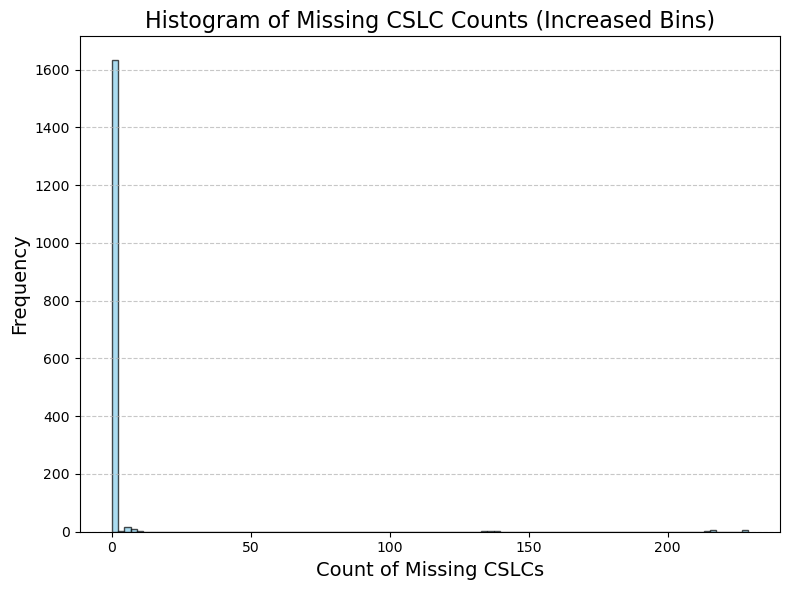

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(missing_data['count_missing_CSLCs'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Missing CSLC Counts (Increased Bins)', fontsize=16)
plt.xlabel('Count of Missing CSLCs', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Read in the geojson and parse the datetime columns

In [41]:
import re
from datetime import date
from datetime import datetime
import geopandas as gpd


# Function to parse the `missing_CSLC_dates` column
def parse_dates(date_str):
    if date_str == '[ ]':  # Handle empty lists
        return []
    
    # Match and extract datetime.date entries
    date_matches = re.findall(r"datetime\.date\((\d+), (\d+), (\d+)\)", date_str)
    
    # Convert matches to date objects (YYYY-MM-DD)
    return [date(year=int(y), month=int(m), day=int(d)) for y, m, d in date_matches]

# Read in the data
data = gpd.read_file('/Users/colespeed/opera/OPERA_Applications/CSLC/troubleshooting/for_others/missing_CSLC_bursts_20160701_20241119.geojson')
# Apply the function to the column
data['missing_CSLC_dates'] = data['missing_CSLC_dates'].apply(parse_dates)
data['duplicate_CSLC_dates'] = data['duplicate_CSLC_dates'].apply(parse_dates)

data.head()

,CSLC_burst_id,count_asfburst,count_operaburst,count_missing_CSLCs,missing_CSLC_dates,count_CSLC_duplicates,duplicate_CSLC_dates,geometry
0,t005_008829_iw1,89,91,1,[2024-11-18],3,"[2023-06-21, 2023-06-21, 2024-04-04, 2024-04-0...","POLYGON Z ((-103.86254 40.1094 0, -102.86147 4..."
1,t005_008829_iw2,89,91,1,[2024-11-18],3,"[2023-06-21, 2023-06-21, 2024-04-04, 2024-04-0...","POLYGON Z ((-102.9087 40.31056 0, -101.85458 4..."
2,t005_008829_iw3,89,91,1,[2024-11-18],3,"[2023-06-21, 2023-06-21, 2024-04-04, 2024-04-0...","POLYGON Z ((-101.89764 40.49926 0, -100.96265 ..."
3,t005_008830_iw1,241,243,1,[2024-11-18],3,"[2023-06-21, 2023-06-21, 2024-04-04, 2024-04-0...","POLYGON Z ((-103.9047 40.27508 0, -102.90106 4..."
4,t005_008830_iw2,241,243,1,[2024-11-18],3,"[2023-06-21, 2023-06-21, 2024-04-04, 2024-04-0...","POLYGON Z ((-102.94841 40.47626 0, -101.89161 ..."


### Decompose the df to all dates

In [43]:
import pandas as pd
# Initialize empty lists to store the results
cslc_burst_ids = []
slc_burst_ids = []
count_asfburst = []	
count_operaburst = []
count_missing_CSLCs = [] 
missing_dates = []
count_CSLC_duplicates = []
duplicate_CSLC_dates = []
geoms = []

# Iterate over each row in the DataFrame
for idx, row in data.iterrows():
    if row['missing_CSLC_dates']:  # Check if there are any missing dates
        # For each missing date, append the corresponding CSLC_burst_id and date
        for missing_date in row['missing_CSLC_dates']:
            cslc_burst_ids.append(row['CSLC_burst_id'])
            slc_burst_ids.append(re.sub(r'^t', '', row['CSLC_burst_id']))
            count_asfburst.append(row['count_asfburst'])
            count_operaburst.append(row['count_operaburst'])
            count_missing_CSLCs.append(row['count_missing_CSLCs'])
            missing_dates.append(missing_date)
            count_CSLC_duplicates.append(row['count_CSLC_duplicates'])
            #duplicate_CSLC_dates.append(row['duplicate_CSLC_dates'])
            geoms.append(row['geometry'])

# Create a new DataFrame with the decomposed lists
decomposed_df = pd.DataFrame({
    'CSLC_burst_id': cslc_burst_ids,
    'SLC_burst_id': slc_burst_ids,
    'count_asfburst': count_asfburst,
    'count_operaburst': count_operaburst,
    'count_missing_CSLCs': count_missing_CSLCs,
    'missing_CSLC_dates': missing_dates,
    'count_CSLC_duplicates': count_CSLC_duplicates,
    #'duplicate_CSLC_dates': duplicate_CSLC_dates,
    'geometry': geoms
})

decomposed_df.head()

,CSLC_burst_id,SLC_burst_id,count_asfburst,count_operaburst,count_missing_CSLCs,missing_CSLC_dates,count_CSLC_duplicates,geometry
0,t005_008829_iw1,005_008829_iw1,89,91,1,2024-11-18,3,"POLYGON Z ((-103.862543 40.109397 0, -102.8614..."
1,t005_008829_iw2,005_008829_iw2,89,91,1,2024-11-18,3,"POLYGON Z ((-102.908698 40.310555 0, -101.8545..."
2,t005_008829_iw3,005_008829_iw3,89,91,1,2024-11-18,3,"POLYGON Z ((-101.897642 40.499255 0, -100.9626..."
3,t005_008830_iw1,005_008830_iw1,241,243,1,2024-11-18,3,"POLYGON Z ((-103.904701 40.275082 0, -102.9010..."
4,t005_008830_iw2,005_008830_iw2,241,243,1,2024-11-18,3,"POLYGON Z ((-102.948409 40.476261 0, -101.8916..."


### Map back to SLC (SAFE file)


In [ ]:
from datetime import timedelta

missing_CSLC_burst_id = []
missing_SLC_burst_id = []
missing_dates = []
SAFE_file_id = []
SLC_geoms = []

for i, burst in enumerate(decomposed_df['SLC_burst_id']):
    
    print(f"working on burst number {i} out of {len(decomposed_df['SLC_burst_id'])} total bursts: {burst}")

    results = asf.search(fullBurstID=[burst], start = (decomposed_df['missing_CSLC_dates'][i]), end = (decomposed_df['missing_CSLC_dates'][i] + timedelta(days=1)))
    file_id = results[0].properties['fileID']

    missing_CSLC_burst_id.append(decomposed_df['CSLC_burst_id'][i])
    missing_SLC_burst_id.append(decomposed_df['SLC_burst_id'][i])
    missing_dates.append(decomposed_df['missing_CSLC_dates'][i])
    SLC_geoms.append(decomposed_df['geometry'][i])
    SAFE_file_id.append(file_id)

working on burst number 0 out of 3986 total bursts: 005_008829_iw1
working on burst number 1 out of 3986 total bursts: 005_008829_iw2
working on burst number 2 out of 3986 total bursts: 005_008829_iw3
working on burst number 3 out of 3986 total bursts: 005_008830_iw1
working on burst number 4 out of 3986 total bursts: 005_008830_iw2
working on burst number 5 out of 3986 total bursts: 005_008830_iw3
working on burst number 6 out of 3986 total bursts: 005_008831_iw1
working on burst number 7 out of 3986 total bursts: 005_008831_iw2
working on burst number 8 out of 3986 total bursts: 005_008831_iw3
working on burst number 9 out of 3986 total bursts: 005_008832_iw1
working on burst number 10 out of 3986 total bursts: 005_008832_iw2
working on burst number 11 out of 3986 total bursts: 005_008832_iw3
working on burst number 12 out of 3986 total bursts: 005_008833_iw1
working on burst number 13 out of 3986 total bursts: 005_008833_iw2
working on burst number 14 out of 3986 total bursts: 005_0

In [46]:
slc = gpd.GeoDataFrame()
slc['CSLC_burst_id'] = missing_CSLC_burst_id
slc['SLC_burst_id'] = missing_SLC_burst_id
slc['missing_CSLC_dates'] = missing_dates
slc['fileID'] = [ids[0] if isinstance(ids, list) else ids for ids in SAFE_file_id]
slc['geometry'] = SLC_geoms

# Check the resulting DataFrame
print(len(slc))
slc.head()

3986


,CSLC_burst_id,SLC_burst_id,missing_CSLC_dates,fileID,geometry
0,t005_008829_iw1,005_008829_iw1,2024-11-18,S1A_IW_SLC__1SDV_20241118T004628_20241118T0046...,"POLYGON Z ((-103.86254 40.1094 0, -102.86147 4..."
1,t005_008829_iw2,005_008829_iw2,2024-11-18,S1A_IW_SLC__1SDV_20241118T004628_20241118T0046...,"POLYGON Z ((-102.9087 40.31056 0, -101.85458 4..."
2,t005_008829_iw3,005_008829_iw3,2024-11-18,S1A_IW_SLC__1SDV_20241118T004628_20241118T0046...,"POLYGON Z ((-101.89764 40.49926 0, -100.96265 ..."
3,t005_008830_iw1,005_008830_iw1,2024-11-18,S1A_IW_SLC__1SDV_20241118T004628_20241118T0046...,"POLYGON Z ((-103.9047 40.27508 0, -102.90106 4..."
4,t005_008830_iw2,005_008830_iw2,2024-11-18,S1A_IW_SLC__1SDV_20241118T004628_20241118T0046...,"POLYGON Z ((-102.94841 40.47626 0, -101.89161 ..."


In [47]:
# Now drop duplicates
slc_unique = slc.drop_duplicates(subset=["CSLC_burst_id", "missing_CSLC_dates"], keep="first")
len(slc_unique)

3986

In [48]:
slc.to_file('missing_CSLC_bursts_20160701_20241119_w_safeID.geojson', driver='GeoJSON')

<h2 style="color:red;">Testing: Parallelize the search and make the final dataframe (Currently not recommended, due to CMR issues)</h2>


### Scale down the dataframe and add a column for SLC burst IDs

In [ ]:
burst_ids = pd.DataFrame()
burst_ids['CSLC_burst_id'] = result_df_intersecting['burst_id_jpl']
burst_ids['SLC_burst_id'] = burst_ids['CSLC_burst_id'].str.replace('^t', '', regex=True)
burst_ids['geometry'] = result_df_intersecting['geometry']
burst_ids = burst_ids.reset_index(drop=True)
burst_ids.head()

In [ ]:
from concurrent.futures import ThreadPoolExecutor

def fetch_results(opts):
    return asf.search(**opts)

opts_list = [
    {
        'dataset': 'SLC-BURST',
        'fullBurstID': list(burst_ids['SLC_burst_id']),
        'polarization': 'VV'
    },
    {
        'dataset': 'OPERA-S1',
        'processingLevel': 'CSLC',
        'operaBurstID': list(burst_ids['CSLC_burst_id'])
    }
]

# Use ThreadPoolExecutor to run API calls in parallel
results = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(fetch_results, opts) for opts in opts_list]
    for future in futures:
        results.append(future.result())

# Unpack the results
SLC_burst_results, CSLC_burst_results = results

### Parse the metadata and add dates/versions to the dataframe

In [ ]:
from collections import defaultdict
import re

# SLCs

# Minimum date filter
min_date = datetime(2016, 7, 1).date()

# Create a dictionary from results
fileID_dict_SLC = defaultdict(list)
for result in SLC_burst_results:
    match = re.search(r'(\d{6}_IW\d)', result.properties['fileID'])
    if match:
        key = match.group(1).lower()  # Normalize case for matching
        # Extract and store only the date part (YYYY-MM-DD)
        date_only = datetime.strptime(result.properties['stopTime'], '%Y-%m-%dT%H:%M:%SZ').date()
        if date_only >= min_date:
            fileID_dict_SLC[key].append(date_only)

# Sort the dates for each fileID
for key in fileID_dict_SLC:
    fileID_dict_SLC[key] = sorted(fileID_dict_SLC[key])

# Map sorted dates to the DataFrame
def get_SLC_dates(row):
    # Extract the relevant portion of the 'id' column
    match = re.search(r'(\d{6}_iw\d)', row['SLC_burst_id'], re.IGNORECASE)
    if match:
        key = match.group(1).lower()
        return fileID_dict_SLC.get(key, [])
    return []

# Apply function to the DataFrame
burst_ids['SLC_sensing_dates'] = burst_ids.apply(get_SLC_dates, axis=1)

In [ ]:
# CSLCs

# Minimum date filter
min_date = datetime(2016, 7, 1).date()

# Create dictionaries for dates and versions
fileID_dict_CSLC = defaultdict(list)
version_dict = defaultdict(list)

for result in CSLC_burst_results:
    match = re.search(r'T(\d{3})-(\d{6})-IW(\d)', result.properties['fileID'])
    if match:
        key = f"t{match.group(1)}_{match.group(2)}_iw{match.group(3)}".lower()  # Normalize to match 'id_2'
        # Extract and store only the date part (YYYY-MM-DD)
        date_only = datetime.strptime(result.properties['stopTime'], '%Y-%m-%dT%H:%M:%SZ').date()
        if date_only >= min_date:
            fileID_dict_CSLC[key].append(date_only)
            version_dict[key].append((date_only, result.properties['pgeVersion']))  # Store date-version pairs

# Sort the dates and corresponding versions for each fileID
for key in fileID_dict_CSLC:
    # Sort dates
    fileID_dict_CSLC[key] = sorted(fileID_dict_CSLC[key])
    # Sort versions by date
    version_dict[key] = [version for date, version in sorted(version_dict[key])]

# Map sorted dates and versions to the DataFrame
def get_CSLC_dates_and_versions(row):
    key = row['CSLC_burst_id'].lower()
    return fileID_dict_CSLC.get(key, []), version_dict.get(key, [])

# Apply function to the DataFrame
burst_ids[['CSLC_sensing_dates', 'versions']] = burst_ids.apply(
    lambda row: pd.Series(get_CSLC_dates_and_versions(row)),
    axis=1
)
burst_ids.head()

### Find SLC burst dates that do not have corresponding CSLC dates and find duplicates
Create a two new columns in the dataframe containing the dates for which SLC bursts exist with no corresponding CSLC bursts and a count of the number of duplicated CSLCs.

In [ ]:
from collections import Counter

# Find missing CSLC dates
def find_diff_dates(row):
    cslc_dates_set = set(row['CSLC_sensing_dates'])
    slc_dates_set = set(row['SLC_sensing_dates'])
    diff_dates = list(slc_dates_set - cslc_dates_set)
    diff_dates.sort()
    return diff_dates

# Function to find grouped duplicates with their corresponding versions
def grouped_duplicates_with_versions(dates, versions):
    # Count occurrences of each date
    counts = Counter(dates)
    
    # Group duplicates and their corresponding versions
    grouped_duplicates = defaultdict(list)  # To store duplicates and their versions
    
    for date, version in zip(dates, versions):
        if counts[date] > 1:  # Check if the date is a duplicate
            grouped_duplicates[date].append(version)
    
    # Convert the dictionary to nested lists of duplicates and versions
    duplicate_dates = [[date] * len(versions) for date, versions in grouped_duplicates.items()]
    duplicate_versions = list(grouped_duplicates.values())
    
    return duplicate_dates, duplicate_versions

# Function to count total duplicates
def count_total_duplicates(grouped_dates):
    return sum(len(group) for group in grouped_dates)

# Function to check if each inner list contains '2.1.1'
def check_contains_version(duplicate_versions, target_version='2.1.1'):
    return [target_version in inner_list for inner_list in duplicate_versions]


# Function to count False values in the 'contains_2.1.1' column
def count_missing_versions(contains_version_list):
    return sum(not value for value in contains_version_list)

# Apply the function to each row and create a new column with the results
burst_ids['missing_CSLC_dates'] = burst_ids.apply(find_diff_dates, axis=1)

# Count total missing CSLC dates
burst_ids['count_missing_CSLCs'] = burst_ids['missing_CSLC_dates'].apply(len)

# Apply the function to create grouped duplicate_CSLC_dates and duplicate_CSLC_versions
burst_ids[['duplicate_CSLC_dates', 'duplicate_CSLC_versions']] = burst_ids.apply(
    lambda row: pd.Series(grouped_duplicates_with_versions(row['CSLC_sensing_dates'], row['CSLC_versions'])),
    axis=1
)

# Apply the function to calculate the total duplicates
burst_ids['count_CSLC_duplicates'] = burst_ids['duplicate_CSLC_dates'].apply(count_total_duplicates)

# Apply the function to calculate the total duplicates
burst_ids['count_CSLC_duplicates'] = burst_ids['duplicate_CSLC_dates'].apply(count_total_duplicates)

# Apply the function to create a new column 'contains_2.1.1'
burst_ids['contains_2.1.1'] = burst_ids['duplicate_CSLC_versions'].apply(check_contains_version)

# Apply the function to create the 'missing_CSLC_version' column
burst_ids['count_missing_CSLC_version_2.1.1'] = burst_ids['contains_2.1.1'].apply(count_missing_versions)

burst_ids.head(5)

### Make the final dataframe
Fields: `cslc_brustID`, `count_asfburst`, `count_operaburst`, `count_missing_cslcs`, `missing_CSLC_date`

In [ ]:
# Get today's date in YYYYMMDD format
today = datetime.today().strftime('%Y%m%d')

missing_data = gpd.GeoDataFrame()
missing_data['CSLC_burst_id'] = burst_ids['CSLC_burst_id']
missing_data['count_asfburst'] = burst_ids['SLC_sensing_dates'].apply(len)
missing_data['count_operaburst'] = burst_ids['CSLC_sensing_dates'].apply(len)
missing_data['count_missing_CSLCs'] = burst_ids['missing_CSLC_dates'].apply(len)
missing_data['missing_CSLC_dates'] = burst_ids['missing_CSLC_dates']
missing_data['count_CSLC_duplicates'] = burst_ids['count_CSLC_duplicates']
missing_data['count_duplicates_missing_CSLC_version_2.1.1'] = burst_ids['count_missing_CSLC_version_2.1.1']
missing_data['geometry'] = burst_ids['geometry']
missing_data.set_geometry('geometry', crs='EPSG:4326', inplace=True)
missing_data.to_file(f'missing_CSLC_bursts_20160701_{today}.geojson', driver='GeoJSON')
missing_data.head()

### Report stats

In [ ]:
print(f"Number of CSLC burst IDs investigated: {len(burst_ids)}")
print(f"Number of CSLC burst IDs with missing dates: {len(data[data['count_missing_CSLCs'] > 0])}")
print(f"Number of CSLC burst IDs with duplicates: {len(data[data['count_CSLC_duplicates'] > 0])}")
print(f"Number of total CSLC duplicates: {data['count_CSLC_duplicates'].sum()}")
print(f"Number of duplicates missing version 2.1.1: {data['count_duplicates_missing_CSLC_version_2.1.1'].sum()}")
print(f"Number of missing CSLC bursts: {data['count_missing_CSLCs'].sum()}")
print(f"Number of CSLCs burst IDs missing zero dates: {len(data[data['count_missing_CSLCs'] == 0])}")
print(f"Number of CSLCs burst IDs missing one date: {len(data[data['count_missing_CSLCs'] == 1])}")
print(f"Number of CSLCs burst IDs missing two dates: {len(data[data['count_missing_CSLCs'] == 2])}")
print(f"Number of CSLCs burst IDs missing three dates: {len(data[data['count_missing_CSLCs'] == 3])}")
print(f"Most frequently missed date: {data['missing_CSLC_dates'].explode().mode()[0]}, with {data['missing_CSLC_dates'].explode().value_counts().max()} missing dates")
print(f"Most frequently missed CSLC burst ID: {data.loc[data['count_missing_CSLCs'].idxmax(), 'CSLC_burst_id']}, with {data['count_missing_CSLCs'].max()} missing dates")